In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import itertools
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import scipy.sparse as sp

# Model Setup

In [2]:
class MF(nn.Module):
    def __init__(self,n_user,n_item,n_factor):
        super().__init__()
        
        self.embed_user=nn.Embedding(n_user,n_factor,sparse=True)
        self.embed_item=nn.Embedding(n_item,n_factor,sparse=True)
        
    def forward(self,i,j):

        latent_user = self.embed_user(i)
        latent_item = self.embed_item(j)
        result=torch.sum(latent_user*latent_item,1)
        return result

# Data

In [29]:
file_name='./data/ml-1m.train.rating'
df=pd.read_csv(file_name,sep='\t',names=['user', 'item','rating'],
               usecols=[0,1,2])
user_num=df['user'].max()+1
item_num=df['item'].max()+1

# train_mat=sp.dok_matrix((user_num,item_num),dtype=np.float32)
# for user,item,rating in df.values:
#     train_mat[user,item]=rating


In [32]:
file_name='./data/ml-1m.test.rating'
df_1=pd.read_csv(file_name,sep='\t',names=['user','item','rating'],usecols=[0,1,2])
df_1.head()

,user,item,rating
0,0,25,5
1,1,133,3
2,2,207,4
3,3,208,4
4,4,222,2


In [84]:
class ratingData():
    def __init__(self,user_num,item_num,train_df):
        self.user_num=user_num
        self.item_num=item_num
        self.df=train_df
        
    def __len__(self):
        return self.df.shape[0]
#         return np.int(self.df.shape[0]/10)
    
    def __getitem__(self,index):
        user_id=torch.tensor(df.iloc[index][0])
        item_id=torch.tensor(df.iloc[index][1])
        rating=torch.tensor(df.iloc[index][2],dtype=torch.float32)
        
        return user_id,item_id,rating

In [86]:
fullData=ratingData(user_num,item_num,df.iloc[:7000])
testData=ratingData(user_num,item_num,df_1.iloc[:600])

In [87]:
fullData.__len__(),testData.__len__()

(7000, 600)

In [6]:
# train_size=int(0.8*df.shape[0])
# test_size=df.shape[0]-train_size
# train_dataset,test_dataset = torch.utils.data.random_split(fullData,
#                                                            [train_size,test_size])

In [88]:
model=MF(n_user=user_num,n_item=item_num,n_factor=30)
BATCH_SIZE=100
loss_fn=nn.MSELoss()
optimizer=torch.optim.SparseAdam(model.parameters(),lr=1e-2)
epochs=100
# trainDataLoader=DataLoader(train_dataset,batch_size=BATCH_SIZE,)
# testDataLoader=DataLoader(test_dataset,batch_size=BATCH_SIZE,)
train_loader=DataLoader(fullData,batch_size=BATCH_SIZE,drop_last=True)
test_loader=DataLoader(testData,batch_size=BATCH_SIZE,drop_last=True)

In [89]:
from tqdm import tqdm_notebook as tqdm

In [90]:
def evaluate(model,testDataLoader):
    step=0
    loss_sum=0.0
    for user,item,rating in tqdm(testDataLoader):
        pred=model(user_id,item_id)
        loss=loss_fn(pred,rating)
        
        loss_sum+=loss.item()
        step+=1
    
    return loss_sum/step

# Train

In [96]:
dfHistory=pd.DataFrame(columns=['epoch','trainLoss','testLoss'])
for epoch in range(1,100+1):
    step=0
    loss_sum=0.0
    model.train()
    for user_id,item_id,rating in tqdm(train_loader):
        pred=model(user_id,item_id)
        loss=loss_fn(pred,rating)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum+=loss.item()
        step+=1

    loss=loss_sum/step
    model.eval()
    loss_val=evaluate(model,test_loader)
    dfHistory.loc[epoch]=(epoch,loss,loss_val)
    print('Epoch {} Loss: {:.2f},Valid_Loss: {:.2f}'.format(epoch,loss,loss_val))


Epoch 1 Loss: 23.95,Valid_Loss: 20.09



Epoch 2 Loss: 18.10,Valid_Loss: 16.19



Epoch 3 Loss: 13.87,Valid_Loss: 13.67



Epoch 4 Loss: 10.81,Valid_Loss: 11.89



Epoch 5 Loss: 8.54,Valid_Loss: 10.49



Epoch 6 Loss: 6.79,Valid_Loss: 9.28



Epoch 7 Loss: 5.40,Valid_Loss: 8.20



Epoch 8 Loss: 4.30,Valid_Loss: 7.20



Epoch 9 Loss: 3.43,Valid_Loss: 6.31



Epoch 10 Loss: 2.75,Valid_Loss: 5.53



Epoch 11 Loss: 2.23,Valid_Loss: 4.86



Epoch 12 Loss: 1.82,Valid_Loss: 4.30



Epoch 13 Loss: 1.50,Valid_Loss: 3.84



Epoch 14 Loss: 1.25,Valid_Loss: 3.47



Epoch 15 Loss: 1.05,Valid_Loss: 3.16



Epoch 16 Loss: 0.89,Valid_Loss: 2.92



Epoch 17 Loss: 0.76,Valid_Loss: 2.72



Epoch 18 Loss: 0.66,Valid_Loss: 2.55



Epoch 19 Loss: 0.57,Valid_Loss: 2.42



Epoch 20 Loss: 0.51,Valid_Loss: 2.32



Epoch 21 Loss: 0.45,Valid_Loss: 2.23



Epoch 22 Loss: 0.40,Valid_Loss: 2.16



Epoch 23 Loss: 0.36,Valid_Loss: 2.10



Epoch 24 Loss: 0.32,Valid_Loss: 2.05



Epoch 25 Loss: 0.29,Valid_Loss: 2.01



Epoch 26 Loss: 0.26,Valid_Loss: 1.97



Epoch 27 Loss: 0.24,Valid_Loss: 1.93



Epoch 28 Loss: 0.22,Valid_Loss: 1.90



Epoch 29 Loss: 0.20,Valid_Loss: 1.88



Epoch 30 Loss: 0.18,Valid_Loss: 1.85



Epoch 31 Loss: 0.17,Valid_Loss: 1.83



Epoch 32 Loss: 0.15,Valid_Loss: 1.81



Epoch 33 Loss: 0.14,Valid_Loss: 1.80



Epoch 34 Loss: 0.13,Valid_Loss: 1.78



Epoch 35 Loss: 0.12,Valid_Loss: 1.77



Epoch 36 Loss: 0.11,Valid_Loss: 1.76



Epoch 37 Loss: 0.11,Valid_Loss: 1.76



Epoch 38 Loss: 0.10,Valid_Loss: 1.75



Epoch 39 Loss: 0.09,Valid_Loss: 1.75



Epoch 40 Loss: 0.09,Valid_Loss: 1.75



Epoch 41 Loss: 0.08,Valid_Loss: 1.74



Epoch 42 Loss: 0.08,Valid_Loss: 1.74



Epoch 43 Loss: 0.07,Valid_Loss: 1.74



Epoch 44 Loss: 0.07,Valid_Loss: 1.74



Epoch 45 Loss: 0.07,Valid_Loss: 1.74



Epoch 46 Loss: 0.06,Valid_Loss: 1.74



Epoch 47 Loss: 0.06,Valid_Loss: 1.74



Epoch 48 Loss: 0.06,Valid_Loss: 1.74



Epoch 49 Loss: 0.05,Valid_Loss: 1.74



Epoch 50 Loss: 0.05,Valid_Loss: 1.74



Epoch 51 Loss: 0.05,Valid_Loss: 1.74



Epoch 52 Loss: 0.05,Valid_Loss: 1.73



Epoch 53 Loss: 0.04,Valid_Loss: 1.73



Epoch 54 Loss: 0.04,Valid_Loss: 1.73



Epoch 55 Loss: 0.04,Valid_Loss: 1.73



Epoch 56 Loss: 0.04,Valid_Loss: 1.73



Epoch 57 Loss: 0.04,Valid_Loss: 1.73



Epoch 58 Loss: 0.03,Valid_Loss: 1.73



Epoch 59 Loss: 0.03,Valid_Loss: 1.73



Epoch 60 Loss: 0.03,Valid_Loss: 1.73



Epoch 61 Loss: 0.03,Valid_Loss: 1.73



Epoch 62 Loss: 0.03,Valid_Loss: 1.73



Epoch 63 Loss: 0.03,Valid_Loss: 1.73



Epoch 64 Loss: 0.03,Valid_Loss: 1.73



Epoch 65 Loss: 0.03,Valid_Loss: 1.73



Epoch 66 Loss: 0.02,Valid_Loss: 1.73



Epoch 67 Loss: 0.02,Valid_Loss: 1.73



Epoch 68 Loss: 0.02,Valid_Loss: 1.73



Epoch 69 Loss: 0.02,Valid_Loss: 1.73



Epoch 70 Loss: 0.02,Valid_Loss: 1.73



Epoch 71 Loss: 0.02,Valid_Loss: 1.73



Epoch 72 Loss: 0.02,Valid_Loss: 1.74



Epoch 73 Loss: 0.02,Valid_Loss: 1.74



Epoch 74 Loss: 0.02,Valid_Loss: 1.74



Epoch 75 Loss: 0.02,Valid_Loss: 1.74



Epoch 76 Loss: 0.02,Valid_Loss: 1.74



Epoch 77 Loss: 0.02,Valid_Loss: 1.74



Epoch 78 Loss: 0.02,Valid_Loss: 1.74



Epoch 79 Loss: 0.01,Valid_Loss: 1.74



Epoch 80 Loss: 0.01,Valid_Loss: 1.74



Epoch 81 Loss: 0.01,Valid_Loss: 1.74



Epoch 82 Loss: 0.01,Valid_Loss: 1.74



Epoch 83 Loss: 0.01,Valid_Loss: 1.74



Epoch 84 Loss: 0.01,Valid_Loss: 1.74



Epoch 85 Loss: 0.01,Valid_Loss: 1.74



Epoch 86 Loss: 0.01,Valid_Loss: 1.74



Epoch 87 Loss: 0.01,Valid_Loss: 1.74



Epoch 88 Loss: 0.01,Valid_Loss: 1.74



Epoch 89 Loss: 0.01,Valid_Loss: 1.74



Epoch 90 Loss: 0.01,Valid_Loss: 1.75



Epoch 91 Loss: 0.01,Valid_Loss: 1.75



Epoch 92 Loss: 0.01,Valid_Loss: 1.75



Epoch 93 Loss: 0.01,Valid_Loss: 1.75



Epoch 94 Loss: 0.01,Valid_Loss: 1.75



Epoch 95 Loss: 0.01,Valid_Loss: 1.75



Epoch 96 Loss: 0.01,Valid_Loss: 1.75



Epoch 97 Loss: 0.01,Valid_Loss: 1.75



Epoch 98 Loss: 0.01,Valid_Loss: 1.75



Epoch 99 Loss: 0.01,Valid_Loss: 1.75



Epoch 100 Loss: 0.01,Valid_Loss: 1.75


# Visualization

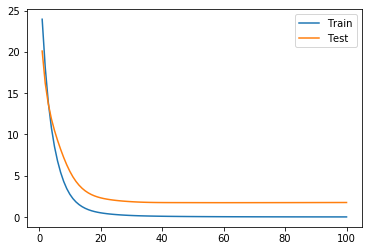

In [98]:
import matplotlib.pyplot as plt
plt.plot(dfHistory['trainLoss'],label='Train')
plt.plot(dfHistory['testLoss'],label='Test')
plt.legend()
plt.show()